In [1]:
# Data: http://share.mailcharts.com/3p213G2D232x
# Headers: id, company name, company id, subject, sent at, discounts

# Goal 1: When will the next email be?
# -- in [n] seconds

In [2]:
from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(4585, 6)

In [4]:
# Add features

def determine_weekday(n):
    if n == 5 or n == 6:
        # weekend
        return 0
    else:
        #weekday
        return 1
    
def determine_am_pm(date):
    return 0 if date.strftime('%p') == "AM" else 1
    
def create_datetime(row):
    return datetime(row["year"],row["month"],row["day"])

# df["promo_not_promo"] = np.where(df["promotion_type"] == "[null]", 0, 1)
df["month"] = df["sent_at"].str.split('-').str.get(1).astype(int)
df["year"] = df["sent_at"].str.split('-').str.get(0).astype(int)
df["day"] = df["sent_at"].str.split('-').str.get(2).str.split(' ').str.get(0).astype(int)
df["weeknum"] = df.apply(lambda x: create_datetime(x).isocalendar()[1], axis=1)
df["am_pm"] = df.apply(lambda x: determine_am_pm(create_datetime(x)), axis=1)
df["weekday_weekend"] = df.apply(lambda x: determine_weekday(create_datetime(x).weekday()), axis=1)

In [5]:
# Get company dummies (we will use this later)

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

,1-800-Flowers.com,1000Bulbs.com,10DollarMall,A'GACI,Abercrombie & Fitch,Ace & Everett,Ace & Tate,Adorama,AllModern,Allurez
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Gather when the previous email was sent
## QUESTION: HOW CAN WE MAKE THIS RUN FASTER

df = df.sort_values("sent_at", ascending=False)
results = []
for index, row in df.iterrows():
    company_emails = df[df["company_id"] == row["company_id"]]
    earlier_emails = list(filter(lambda x: x < row["sent_at"], company_emails["sent_at"]))
    if len(earlier_emails) > 0:
        results.append(earlier_emails[0])
        continue
    else:
        results.append(None)

# Save the results to our dataframe
df["prev_email"] = results

In [96]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == None:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["prev_email_delta"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)

# QA that we only have 1 time_delta with a value of 0
df[df["prev_email_delta"] == 0]["company_name"].value_counts()

Ace & Tate             1
10DollarMall           1
AllModern              1
1000Bulbs.com          1
1-800-Flowers.com      1
Adorama                1
Ace & Everett          1
Allurez                1
A'GACI                 1
Abercrombie & Fitch    1
Name: company_name, dtype: int64

In [8]:
# Merge both dataframes

data = pd.merge(df, dummy_company, right_index=True, left_index=True)

In [10]:
data.head()

# Drop the columns we don't need
data = data.drop(["company_name", "subject", "sent_at", "id"], axis=1)

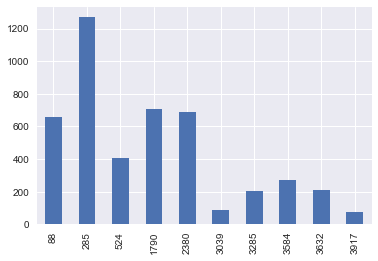

In [11]:
# Visualize the send volume to understand the data a bit better

email_counts_sum = data["company_id"].value_counts().sort_index(axis=0)

email_counts_sum.plot(kind='bar')

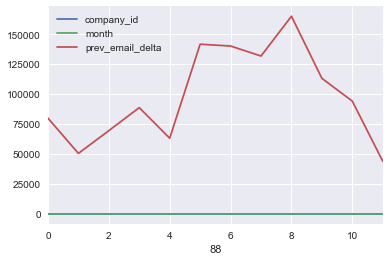

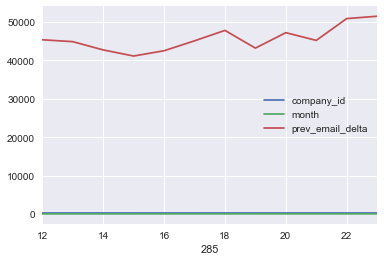

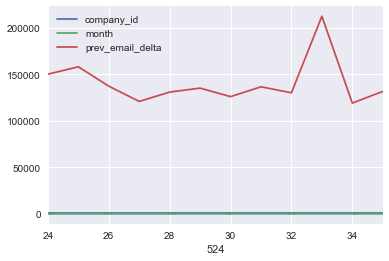

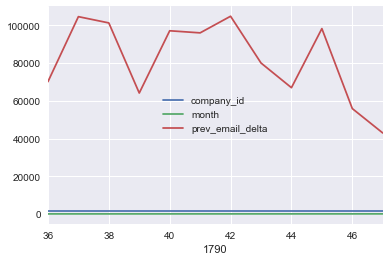

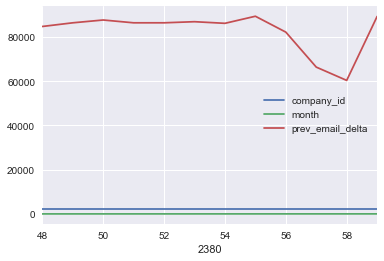

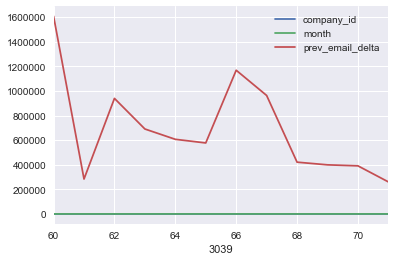

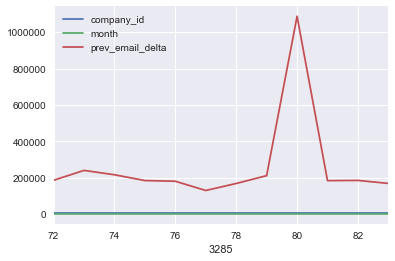

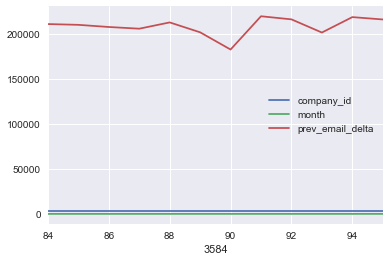

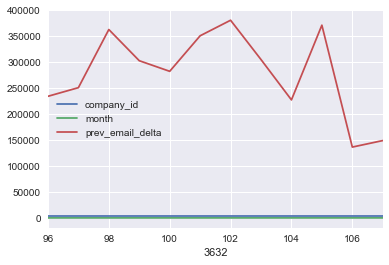

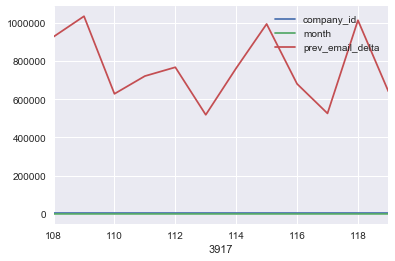

In [12]:
# Let's analyze the sending behavior of these companies
# Takeaway: They all have their own sending behavior!
# Note: Spikes == more time in between emails

time_delta_average_by_month = data.groupby(by=['company_id', 'month'])["prev_email_delta"].mean().reset_index()
c_id = time_delta_average_by_month["company_id"].unique()

for i in c_id:
    plot = time_delta_average_by_month[time_delta_average_by_month["company_id"] == i].plot()
    plot.set_xlabel(i)


In [30]:
# Get the time-delta for each company
data.groupby(["industry_name", "company_id"]).prev_email_delta.mean().reset_index().sort_values("prev_email_delta")

,industry_name,company_id,prev_email_delta
5,retail,285,44965.040157
3,photography,1790,80291.944915
0,e-commerce,2380,82759.116110
4,retail,88,86788.738204
6,retail,524,139194.107579
1,lighting,3584,207690.102941
2,other,3917,728605.461538


[]

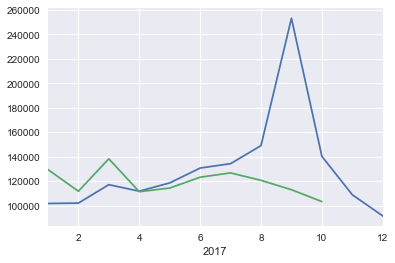

In [61]:
# Let's analyze the data by month

fig, axes = plt.subplots()
f1 = data[data.year==2016].groupby("month").prev_email_delta.mean().plot(ax=axes, label="2016")
f2 = data[data.year==2017].groupby("month").prev_email_delta.mean().plot(ax=axes, label="2017")

# Labels are not working =/
f1.set_xlabel("2016")
f2.set_xlabel("2017")
plt.plot()

# We can definitely see the impact of seasonality

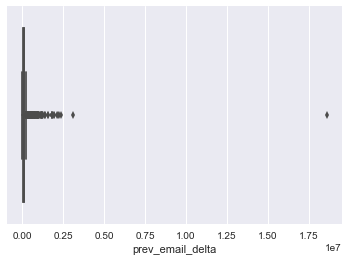

In [77]:
sns.boxplot(x=data["prev_email_delta"])

# We have some outliers! We need to remove them

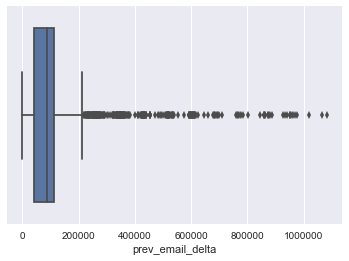

In [78]:
stdev = data.prev_email_delta.std()
mean = data.prev_email_delta.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

non_outliers = data[(data.prev_email_delta >=lower_bound) & (data.prev_email_delta <= upper_bound)]

sns.boxplot(x=non_outliers["prev_email_delta"])

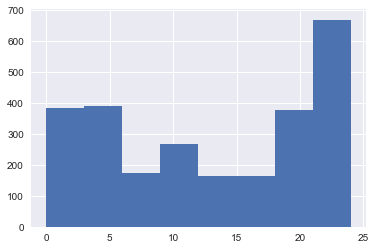

In [89]:
data["readable_time_delta"] = data["prev_email_delta"] / 60 / 60
data.readable_time_delta.hist(bins = [0, 3, 6, 9, 12, 15, 18, 21, 24])

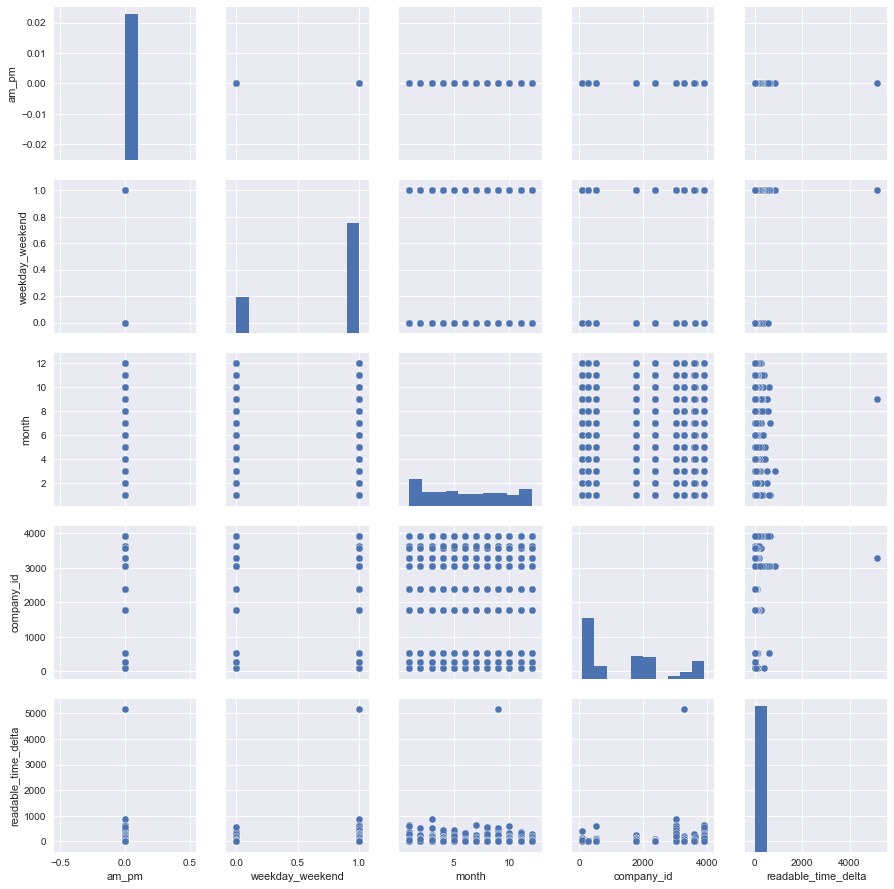

In [95]:
sns.pairplot(data[["am_pm", "weekday_weekend", "month", "company_id", "industry_name", "readable_time_delta"]])

Features we want:

- Month
- Company
- Industry
- am_pm
- weekend

Models:

- linear regression
- decision tree regressor

Homework:

- Remove outliers
- Clean up code and comment it

## Homework
- [x] Average time delta for each company.
  - [x] Same for average time by month.
- [x] Get more historical data. Look at seasonality by month.
- [x] Fix promotional / not promotional.
- Look at outliers
- [x] Add company tags / categories

## Models to use – brainstorm
**Question: When will the next email be?**

- Linear regression

**Will the next email be a discount?**

- Random forrest (DecisionTreeClassifier)

**How much will they discount by?**

- SVM